In [1]:
import pandas as pd 
import seaborn as sns
from scipy import stats
from matplotlib import pyplot as plt
import os
import geopandas as gpd
import sys
import scipy.stats as stats

In [2]:
cwd = os.getcwd()
print(cwd)
dataPath = os.path.join(cwd, 'data')
austin_housing = pd.read_csv(os.path.join(dataPath, 'crime-housing-austin-2015.csv'))
zip_codes = pd.read_csv(os.path.join(dataPath, 'AustinZipCodes.csv'))

C:\Users\Bethany\Documents\2024-Spring\CS5830\Assn2-crime


In [3]:
austin_housing.head()
austin_housing.columns

Index(['Key', 'Council_District', 'Highest_Offense_Desc',
       'Highest_NIBRS_UCR_Offense_Description', 'Report_Date', 'Location',
       'Clearance_Status', 'Clearance_Date', 'District', 'Zip_Code_Crime',
       'Census_Tract', 'X_Coordinate', 'Y_Coordinate', 'Zip_Code_Housing',
       'Populationbelowpovertylevel', 'Medianhouseholdincome',
       'Non-WhiteNon-HispanicorLatino', 'HispanicorLatinoofanyrace',
       'Populationwithdisability', 'Unemployment',
       'Largehouseholds(5+members)',
       'Homesaffordabletopeopleearninglessthan$50000',
       'Rentalsaffordabletopeopleearninglessthan$25000',
       'Rent-restrictedunits', 'HousingChoiceVoucherholders', 'Medianrent',
       'Medianhomevalue', 'Percentageofrentalunitsinpoorcondition',
       'Percentchangeinnumberofhousingunits2000-2012',
       'Ownerunitsaffordabletoaverageretail/serviceworker',
       'Rentalunitsaffordabletoaverageretail/serviceworker',
       'Rentalunitsaffordabletoaverageartist',
       'Ownerunits

In [4]:
# zip_codes.head()
zip_codes.columns
zip_codes.tail()

Index(['#', 'Zip Code', 'Location', 'City', 'Population', 'People / Sq. Mile',
       'National Rank'],
      dtype='object')

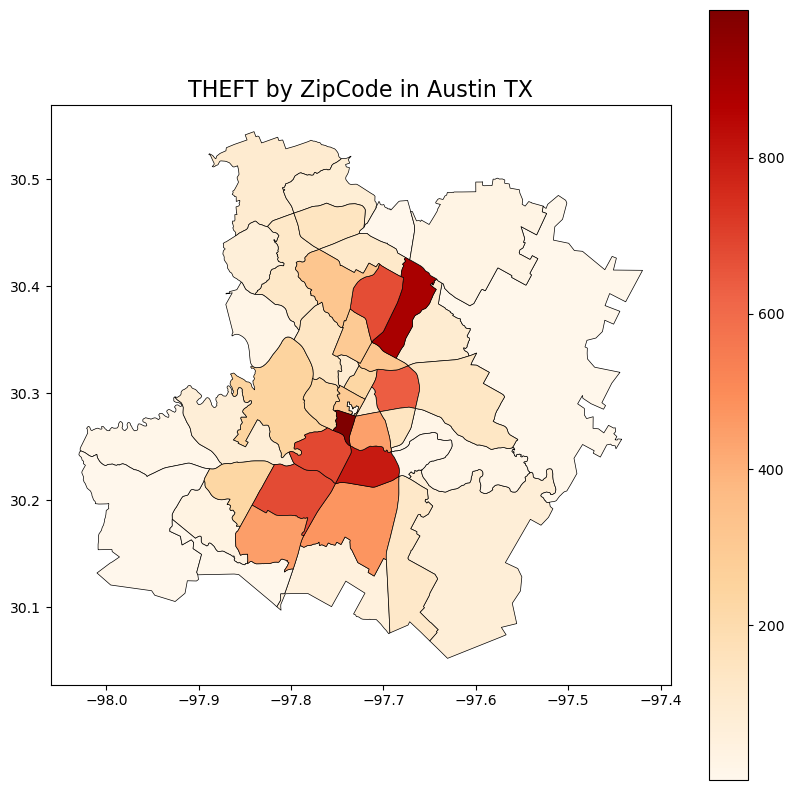

In [5]:
""" 
Karl's Spatial Analysis 
"""

""" 
Map of Austin TX  
https://openaustin.carto.com/u/oa-admin/tables/austin_area_zip_codes/public?redirected=true 
"""

df = austin_housing.copy()
# Date format: 01-Jan-15.  d=day, b=abbreviated month,y=2-digit year
# df['Report_Date'] = pd.to_datetime(df['Report_Date'], format='%d-%b-%y')

# Aggregate crimes by zip code
crime_zip = df[['Zip_Code_Crime', 'Highest_Offense_Desc']].copy()
crime_zip.rename(columns={'Zip_Code_Crime': 'Zip_Code'}, inplace=True)
crime_zip.dropna(inplace=True)
crime_zip['Zip_Code'] = crime_zip['Zip_Code'].astype('int').astype('str')
crime_zip.groupby(['Zip_Code', 'Highest_Offense_Desc']).count()
crime_zip['Total_Crime'] = crime_zip.groupby(['Zip_Code', 'Highest_Offense_Desc'])['Highest_Offense_Desc'].transform('count')

# Process the crime_zip df to get zip codes and remove duplicates
crime_zip.drop_duplicates(subset=['Zip_Code'], inplace=True)
crime_zip.sort_values(by=['Total_Crime'], ascending=False, inplace=True)
crime_zip.reset_index(drop=True, inplace=True)
crime_zip.drop(columns=['Highest_Offense_Desc'], inplace=True)
crime_zip['Total_Crime'] = crime_zip['Total_Crime'].astype('int')

# Remove zip codes that do not show up in the AustinZipCodes.csv
# display the missing zip codes
missing_zip_codes = crime_zip[~crime_zip['Zip_Code'].isin(zip_codes['Zip Code'].astype('str'))]
crime_zip = crime_zip[crime_zip['Zip_Code'].isin(zip_codes['Zip Code'].astype('str'))]
print(f'missing zip codes: {missing_zip_codes}')

# Load the GeoDataFrame and merge it with crime_zip
austinMap = gpd.read_file(os.path.join(dataPath, 'austin_area_zip_codes.geojson'))
austinMap['zipcode'] = austinMap['zipcode'].astype('str')

# Merge num crimes per zip with the austin map 
austinMapCrimeZip = austinMap.copy()
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
austinMapCrimeZip = austinMapCrimeZip.merge(crime_zip, left_on='zipcode', right_on='Zip_Code', how='left')

# Plot the GeoDataFrame
austinMapCrimeZip.plot(ax=ax, figsize=(10, 10), column='Total_Crime', cmap='OrRd', linewidth=0.5, edgecolor='black', legend=True)
ax.set_title('Total Crime by ZipCode in Austin TX', fontsize=16)
plt.show()



"""
Make a new column, titled theft_crime_rate, that is the number of crimes per 1000 people
"""
crime_rate = crime_zip[['Zip_Code', 'Total_Crime']].copy()
population_zip = pd.read_csv(os.path.join(dataPath, 'AustinZipCodes.csv'))
population_zip = population_zip[['Zip Code', 'Population']].copy()
population_zip['Zip Code'] = population_zip['Zip Code'].astype('str')

# Convert population into an int
population_zip['Population'] = population_zip['Population'].str.replace(',', '')
population_zip['Population'] = population_zip['Population'].astype('int')

# Merge population_zip with crime_rate
crime_rate = crime_rate.merge(population_zip, left_on='Zip_Code', right_on='Zip Code', how='left')
crime_rate['crime_per_1000'] = crime_rate['Total_Crime'] / (crime_rate['Population'] / 1000)
crime_rate.sort_values(by=['crime_per_1000'], ascending=False, inplace=True)
crime_rate.drop(columns=['Total_Crime', 'Zip Code', 'Population'], inplace=True)
crime_rate['crime_per_1000'] = crime_rate['crime_per_1000'].fillna(0)
# crime_rate.dropna(inplace=True)
print(crime_rate.head(5))
print(crime_rate.info())

# Plot the population with the geojson map 
# Analysis: How correlated is the number of crimes to the population of a zip code?
austinMapCrimeRate = austinMap.copy()
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
austinMapCrimeRate = austinMapCrimeRate.merge(crime_rate, left_on='zipcode', right_on='Zip_Code', how='left')
austinMapCrimeRate.plot(ax=ax, figsize=(10, 10), column='crime_per_1000', 
                        cmap='OrRd', linewidth=0.5, edgecolor='black', 
                        legend=True, )
ax.set_title('Total Crime per 1000 residents in Austin TX', fontsize=16)
plt.show()


# Conduct a t-test on crime rates and zip codes
# Calculate Pearson correlation coefficient and p-value
# Perform Kruskal-Wallis test
statistic, p_value = stats.kruskal(*[group["crime_per_1000"] for name, group in crime_rate.groupby("Zip_Code")])

# Output results
print(f"Kruskal-Wallis H-statistic: {statistic}")
print(f"P-value: {p_value}")

print("The Kruskal-Wallis test is NOT significant. We fail to reject the null hypothesis that the crime rates are the same across all zip codes.")
print("Conclusion: The crime rates are not significantly different across all zip codes.")




In [6]:
""" 
Bethany's Analysis
"""
# grab crimes and dates
crime_by_date = df[['Report_Date', 'Highest_Offense_Desc']].copy()
# crime_by_date = crime_by_date[crime_by_date.Highest_Offense_Desc != "THEFT"]
# crime_by_date = crime_by_date[crime_by_date.Highest_Offense_Desc != "BURGLARY OF VEHICLE"]
# crime_by_date = crime_by_date[crime_by_date.Highest_Offense_Desc != "THEFT BY SHOPLIFTING"]
# crime_by_date = crime_by_date[crime_by_date.Highest_Offense_Desc != "BURGLARY OF RESIDENCE"]



# create month column, define order of months
crime_by_date["Month"] = crime_by_date['Report_Date'].apply(lambda x : x.split('-')[1])
month_order = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
crime_by_date["Month"] = pd.Categorical(crime_by_date['Month'], categories=month_order, ordered=True)

# groupby month and crime. Sum the total of each crime per month
crime_by_month = crime_by_date.groupby(["Month", "Highest_Offense_Desc"]).agg(Total_Reportings=('Highest_Offense_Desc', 'count')).reset_index()

# groupby month, grab the rows for the crimes with the highest total reportings that month
crime_by_month_idx = crime_by_month.groupby("Month")["Total_Reportings"].idxmax()
crime_of_the_month = crime_by_month.loc[crime_by_month_idx]

# crime_of_the_month

Text(0.5, 1.0, 'Crime of the Month')

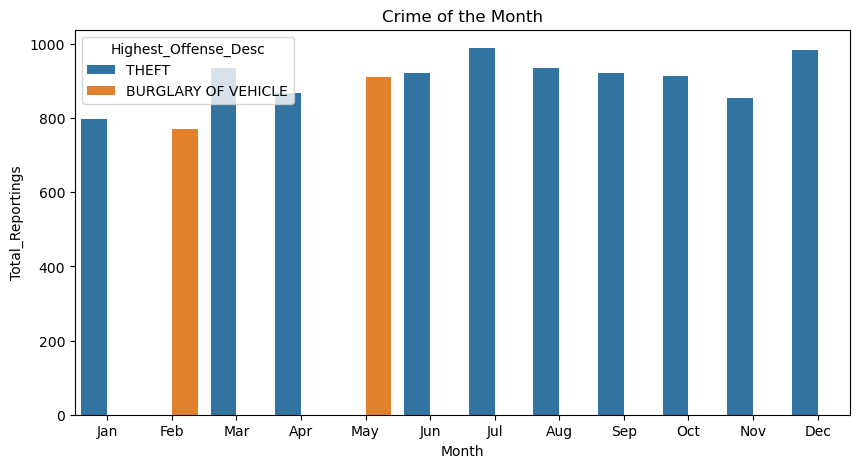

In [7]:
plt.figure(figsize=(10, 5))

sns.barplot(data=crime_of_the_month, x='Month', y='Total_Reportings', hue='Highest_Offense_Desc').set_title("Crime of the Month")

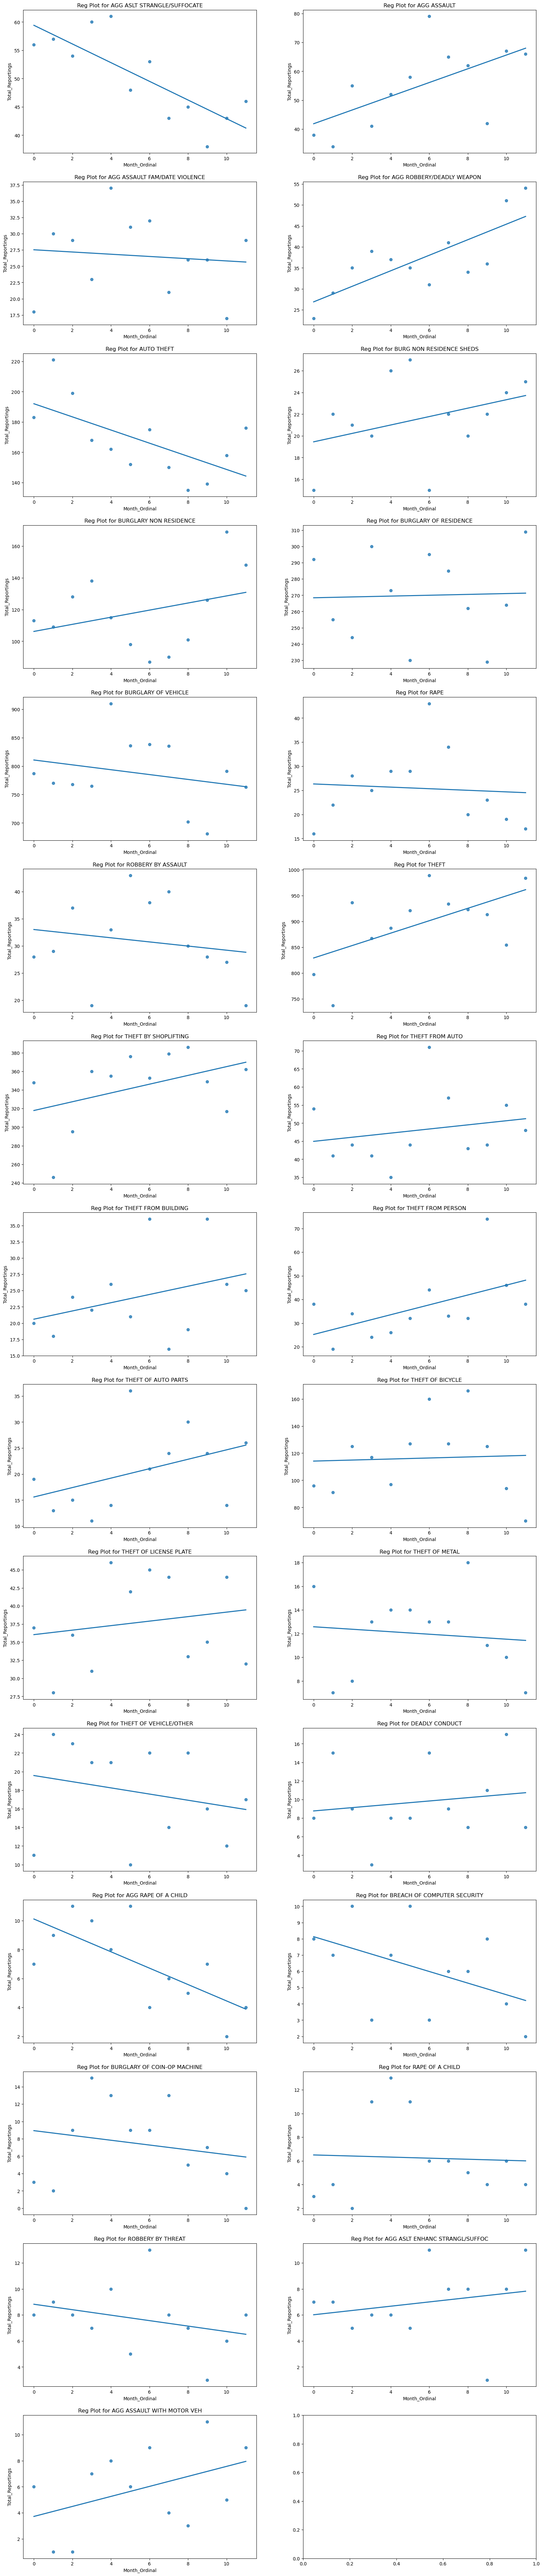

In [8]:
"""
Also Bethany's Analysis
"""

# create a new column in crime_by_month df with the ordinal value for the months
crime_by_month["Month_Ordinal"] = crime_by_month["Month"].apply(lambda x: month_order.index(x))

# identify the crimes with more than 10 reportings total (29 columns)
crimes_over_10 = crime_by_month[crime_by_month.Total_Reportings >= 10]["Highest_Offense_Desc"].unique()

# define a dictionary for storing the pearson r results
cor_results = {}

# plot a regplot for each crime over time.
fig, axes = plt.subplots(15, 2, figsize=(20, 100))
axes = axes.flatten()
for i, crime in enumerate(crimes_over_10):
    crime_data = crime_by_month[crime_by_month['Highest_Offense_Desc'] == crime]
    sns.regplot(
        data=crime_data,
        x="Month_Ordinal",
        y="Total_Reportings",
        ax=axes[i],
        ci=None
    )
    axes[i].set_title(f'Reg Plot for {crime}')
#     axes[i].set(xticks =month_order)
    # store pearson r result per crime
    cor = stats.pearsonr(crime_data.Month_Ordinal, crime_data.Total_Reportings)
    cor_results[crime] = cor

# turn result dictionary into dataframe, rename columns
result_df = pd.DataFrame(cor_results).T
result_df.columns = ["statistic", "pvalue"]

In [9]:
# display pearson r values for each crime
display(result_df)
display(result_df[result_df.pvalue <= 0.05])

,statistic,pvalue
AGG ASLT STRANGLE/SUFFOCATE,-0.794728,0.002010
AGG ASSAULT,0.619100,0.031827
AGG ASSAULT FAM/DATE VIOLENCE,-0.103623,0.748606
AGG ROBBERY/DEADLY WEAPON,0.772926,0.003201
AUTO THEFT,-0.631908,0.027498
BURG NON RESIDENCE SHEDS,0.368163,0.238996
BURGLARY NON RESIDENCE,0.329116,0.296213
BURGLARY OF RESIDENCE,0.034495,0.915245
BURGLARY OF VEHICLE,-0.247490,0.438020
RAPE,-0.076326,0.813619


,statistic,pvalue
AGG ASLT STRANGLE/SUFFOCATE,-0.794728,0.002010
AGG ASSAULT,0.619100,0.031827
AGG ROBBERY/DEADLY WEAPON,0.772926,0.003201
AUTO THEFT,-0.631908,0.027498
THEFT,0.592615,0.042297
AGG RAPE OF A CHILD,-0.698639,0.011486
